# Simulation Examples

This notebook uses simulations to introduce and explore key points about aperiodic neural activty for the aperiodic-clinical project. 

Tooling:
- Time domain simulations and analyses are done with the [neurodsp](https://neurodsp-tools.github.io/) module.
- Frequency domain simulations and spectral parameterization are done with the [specparam](https://specparam-tools.github.io/) module.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_combined
from neurodsp.utils import create_times
from neurodsp.plts import plot_time_series
from neurodsp.spectral import compute_spectrum
from neurodsp.spectral.utils import rotate_powerlaw
from neurodsp.utils import set_random_seed

from specparam import SpectralModel, Bands
from specparam.plts import plot_spectra
from specparam.plts.utils import add_shades
from specparam.utils import trim_spectrum

In [2]:
# Import local code
from local.utils import compute_abs_power
from local.plts import savefig

In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
set_random_seed(13)

### Plot Settings

In [5]:
# Plot settings
BANDS = Bands({
    'theta' : [3, 8],
    'alpha' : [8, 13],
    'beta' : [13, 35],
})

BAND_COLORS = {
    'theta' : '#46b870',
    'alpha' : '#1882d9',
    'beta'  : '#a218d9',
}

# Plot settings
SIG_COLORS = {
    'col1' : '#3a11f0',  # '#1653b5'
    'col2' : '#f01145',  # '#7716c7'
}

In [6]:
# Define figure save path folder
save_folder = './figs/'

In [7]:
# Set plot run settings
SAVE_FIG = False

### Simulation Settings

In [8]:
# Simulation settings
fs = 500
n_seconds = 120

In [9]:
# Create a times vector
times = create_times(n_seconds, fs)

### Analysis Settings

In [10]:
# Spectrum / fit settings
fit_range = [2, 40]

## Simulations

In [11]:
# Define simulation parameters for single example signal
comps = {'sim_powerlaw' : {'exponent' : -1.25, 'f_range' : [1., 55]}, 
         'sim_bursty_oscillation' : {'freq' : 10, 'enter_burst' : 0.25, 'leave_burst' : 0.3}}

In [12]:
# Simulate signal
sig = sim_combined(n_seconds, fs, comps, [0.75, 1])

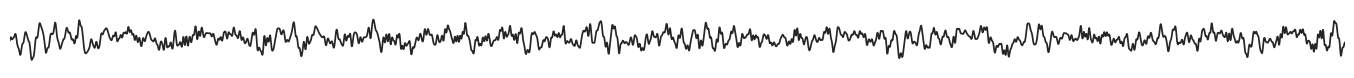

In [13]:
# Plot the time series
plot_time_series(times, sig, lw=1.25, alpha=0.85, xlim=[8, 18], figsize=(15, 1.75))
plt.gca().axis('off');
savefig(SAVE_FIG, 'time_series.pdf', save_folder)

#### Power Spectrum Analysis

In [14]:
# Compute the power spectrum
freqs, powers = compute_spectrum(sig, fs, nperseg=1.5*fs, noverlap=fs)

In [15]:
# Fit a spectral model to the example signal
fm = SpectralModel(verbose=False)
fm.fit(freqs, powers, freq_range=fit_range)

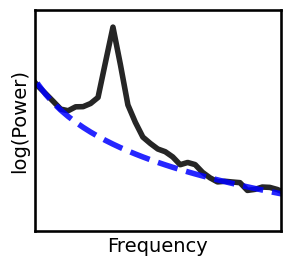

In [16]:
# Plot the power spectrum - no band shading
_, ax = plt.subplots(figsize=(3.25, 3))
plot_spectra(fm.data.freqs, [fm.data.power_spectrum, fm.results.model._ap_fit], 
             alpha=0.85, log_freqs=False, log_powers=False, 
             lw=4, colors=['black', 'blue'], 
             ylabel='log(Power)', linestyle=['-', '--'],
             xlim=[3, 25], ylim=[-2.7, -0.45], ax=ax)
ax.set(xticks=[], yticks=[])
savefig(SAVE_FIG, 'spectrum_noshade.pdf', save_folder)

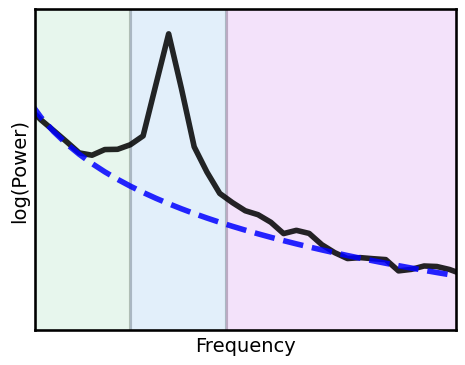

In [17]:
# Plot the power spectrum - with band shading
_, ax = plt.subplots(figsize=(5, 4))
plot_spectra(fm.data.freqs, [fm.data.power_spectrum, fm.results.model._ap_fit], 
             alpha=0.85, log_freqs=False, log_powers=False, 
             lw=4, colors=['black', 'blue'], 
             ylabel='log(Power)', linestyle=['-', '--'],
             xlim=[3, 25], ylim=[-2.7, -0.45], ax=ax)
ax.set(xticks=[], yticks=[])

ax.axvline(8, color='grey', linestyle='-', alpha=0.5, zorder=0)
ax.axvline(13, color='grey', linestyle='-', alpha=0.5, zorder=0)

add_shades(ax,
           [BANDS['theta'], BANDS['alpha'], BANDS['beta']],
           colors=[BAND_COLORS['theta'], BAND_COLORS['alpha'], BAND_COLORS['beta']],
           shade_alpha=0.125, logged=False)

savefig(SAVE_FIG, 'spectrum.pdf', save_folder)

## Comparison

In [18]:
# Create a second signal - rotated version of the first
powers2 = rotate_powerlaw(freqs, powers, -0.5, f_rotation=12.5)

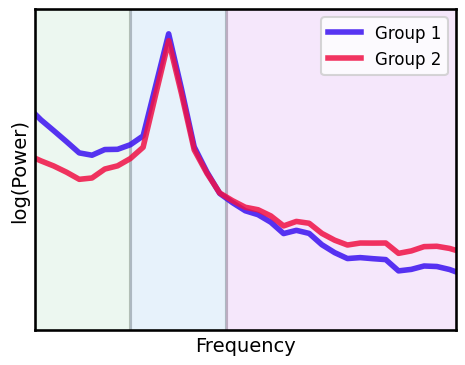

In [19]:
# Plot the spectrum comparisons plot
_, ax = plt.subplots(figsize=(5, 4))
plot_spectra(freqs,
             [powers, powers2],
             labels=['Group 1', 'Group 2'],
             alpha=0.85, log_freqs=False, log_powers=True, 
             lw=4, colors=[SIG_COLORS['col1'], SIG_COLORS['col2']],
             ylabel='log(Power)', xlim=[3, 25], ylim=[-2.7, -0.45], 
             ax=ax)
ax.set(xticks=[], yticks=[])

ax.axvline(8, color='grey', linestyle='-', alpha=0.5, zorder=0)
ax.axvline(13, color='grey', linestyle='-', alpha=0.5, zorder=0)

add_shades(ax,
           [BANDS['theta'], BANDS['alpha'], BANDS['beta']],
           colors=[BAND_COLORS['theta'], BAND_COLORS['alpha'], BAND_COLORS['beta']],
           shade_alpha=0.10, logged=False)

savefig(SAVE_FIG, 'spectrum_comp.pdf', save_folder)

### Compute Measures

In [20]:
# Fit a spectral model to the example signal
fm2 = SpectralModel(verbose=False)
fm2.fit(freqs, powers2, freq_range=fit_range)

In [21]:
# Get the aperiodic exponent values from the fit models
exp1 = fm.get_params('aperiodic', 'exponent')
exp2 = fm2.get_params('aperiodic', 'exponent')

In [22]:
# Compare exponents
print('Sig1 - exponent: \t{:+1.2f}'.format(exp1))
print('Sig2 - exponent: \t{:+1.2f}'.format(exp2))
print('Exponent difference: \t{:1.2f}'.format(exp2 - exp1))

Sig1 - exponent: 	+1.27
Sig2 - exponent: 	+0.77
Exponent difference: 	-0.50


In [23]:
# Compute differences across band ranges
diffs = {}
for label, frange in BANDS.bands.items():
    p1 = compute_abs_power(freqs, powers, frange)
    p2 = compute_abs_power(freqs, powers2, frange)
    diffs[label] = p2 - p1

In [24]:
# Check the band-specific power differences
print('Band differences:')
for label, diff in diffs.items():
    print('\t', label, '\t\t{:+1.4f}'.format(diff))

Band differences:
	 theta 		-0.1157
	 alpha 		-0.0647
	 beta 		+0.0592
